In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")
# style.use("fivethirtyeight")


In [11]:
import dowhy
from dowhy import CausalModel
import statsmodels.formula.api as smf

In [21]:
# import os
# os.chdir('c:\\Users\\Zain\\Desktop\\Github\\CausalInference\\')

## Matching

In [32]:
df = pd.read_csv("Data/drug_impact.csv")
df.head(5)

,sex,age,severity,medication,recovery
0,0,35.049134,0.887658,1,31
1,1,41.580323,0.899784,1,49
2,1,28.127491,0.486349,0,38
3,1,36.375033,0.323091,0,35
4,0,25.091717,0.209006,0,15


In [33]:
df.query("medication==1")["recovery"].mean() - df.query("medication==0")["recovery"].mean()

In [34]:
X = ["severity", "age", "sex"]
y = "recovery"
df = df.assign(**{f: (df[f] - df[f].mean())/df[f].std() for f in X})
df.head()

,sex,age,severity,medication,recovery
0,-0.996980,0.280787,1.459800,1,31
1,1.002979,0.865375,1.502164,1,49
2,1.002979,-0.338749,0.057796,0,38
3,1.002979,0.399465,-0.512557,0,35
4,-0.996980,-0.610473,-0.911125,0,15


In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

treated = df[df['medication']==1]
untreated = df[df['medication']==0]

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[y])


# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(untreated[X], untreated[y])
ols1 = LinearRegression().fit(treated[X], treated[y])

# find the units that match to the treated
treated_match_index = mt0.kneighbors(treated[X], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd
untreated_match_index = mt1.kneighbors(untreated[X], n_neighbors=1)[1].ravel()

# find the Y match on the other group
treated['match']=mt0.predict(treated[X])
untreated['match']=mt1.predict(untreated[X])

# build the bias correction term
treated['bias_correct'] =ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X])
untreated['bias_correct'] =ols1.predict(untreated[X]) - ols1.predict(treated.iloc[untreated_match_index][X])

predicted = pd.concat([treated, untreated])

predicted.head()



,sex,age,severity,medication,recovery,match,bias_correct
0,-0.996980,0.280787,1.459800,1,31,39.0,4.404034
1,1.002979,0.865375,1.502164,1,49,52.0,12.915348
7,-0.996980,1.495134,1.268540,1,38,46.0,1.871428
10,1.002979,-0.106534,0.545911,1,34,45.0,-0.496970
16,-0.996980,0.043034,1.428732,1,30,39.0,2.610159


In [46]:
np.mean((2*predicted["medication"] - 1)*((predicted["recovery"] - predicted["match"])-predicted["bias_correct"]))

## Propensity score stratification

In [11]:
df = pd.read_csv("Data/drug_impact.csv")
df = df.astype({'medication':'bool'}, copy=False)
model=CausalModel(
        data = df,
        treatment='medication',
        outcome='recovery',
        common_causes=['sex', 'age', 'severity'])
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
#print(estimate)
print("The Causal Estimate is " + str(estimate.value))

The Causal Estimate is -10.436715893220788


## Propensity score weighting

In [47]:
df = pd.read_csv("Data/lalonde_new.csv")
df.head()

,age,educ,black,hisp,married,nodegr,re78,treat
0,37,11,1,0,1,1,9930.05,1
1,22,9,0,1,0,1,3595.89,1
2,30,12,1,0,0,0,24909.50,1
3,27,11,1,0,0,1,7506.15,1
4,33,8,1,0,0,1,289.79,1


In [48]:
smf.ols("re78 ~ treat +age+educ+black+married+nodegr+hisp", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1168.0115,3360.589,0.348,0.728,-5436.915,7772.938
treat,1671.1309,637.973,2.619,0.009,417.254,2925.008
age,52.8219,45.255,1.167,0.244,-36.123,141.767
educ,393.8208,227.114,1.734,0.084,-52.550,840.192
black,-2220.2623,1168.317,-1.900,0.058,-4516.481,75.957
married,158.2097,850.327,0.186,0.852,-1513.028,1829.448
nodegr,-128.2219,995.416,-0.129,0.898,-2084.620,1828.176
hisp,83.7170,1550.348,0.054,0.957,-2963.349,3130.783


In [50]:
from sklearn.linear_model import LogisticRegression

T = 'treat'
Y = 'achievement_score'
X = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr']

ps_model = LogisticRegression(C=1e6).fit(df[X], df[T])

data_ps = df.assign(propensity_score=ps_model.predict_proba(df[X])[:, 1])
smf.ols("re78 ~ treat + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3009.2709,1480.525,2.033,0.043,99.527,5919.015
treat,1667.6743,643.387,2.592,0.010,403.196,2932.153
propensity_score,3844.3054,3540.043,1.086,0.278,-3113.102,1.08e+04


In [51]:
df = df.astype({'treat':'bool'}, copy=False)
model=CausalModel(
        data = df,
        treatment='treat',
        outcome='re78',
        common_causes='nodegr+black+hisp+age+educ+married'.split('+'))
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                          
────────(Expectation(re78|nodegr,educ,married,black,hisp,age))
d[treat]                                                      
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,nodegr,educ,married,black,hisp,age,U) = P(re78|treat,nodegr,educ,married,black,hisp,age)

## Realized estimand
b: re78~treat+nodegr+educ+married+black+hisp+age
Target units: ate

## Estimate
Mean value: 1614.0711994355534



In [52]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:1614.0711994355534
New effect:1611.6033340610547



In [53]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:1614.0711994355534
New effect:-241.82714635600715
p value:0.3747410780825138



In [54]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(res_subset)

Refute: Use a subset of data
Estimated effect:1614.0711994355534
New effect:1632.8764392450894
p value:0.41



## Doubly robust regression

In [16]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )
T = 'treat'
Y = 're78'
X = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr']

doubly_robust(df, X, T, Y)

## Regression discontinuity design

In [13]:
df = pd.read_csv("Data/drinking.csv")
df = df[["agecell", "all", "mva", "suicide"]]
df.head()

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


In [14]:
df["score"] = df["agecell"]+79
df["engagement"] = df["all"]

df= df[["score", "engagement"]]

In [15]:
df.head()

,score,engagement
0,98.068493,92.825400
1,98.150684,95.100740
2,98.232876,92.144295
3,98.315070,88.427760
4,98.397260,88.704940


In [16]:
df["score"] -= 100
rdd_df = df.assign(threshold=(df["score"] > 0).astype(int))

model = smf.wls("engagement~score*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
score,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
score:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


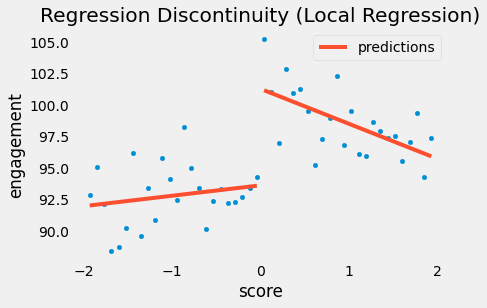

In [17]:
ax = df.plot.scatter(x="score", y="engagement", color="C0")
df.assign(predictions=model.fittedvalues).plot(x="score", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)")
plt.grid(None);

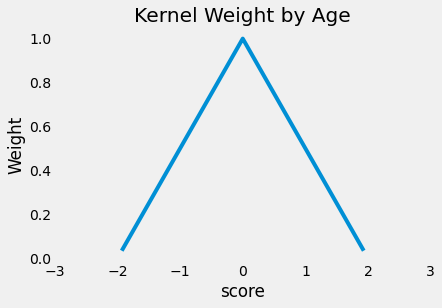

In [31]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

plt.plot(df["score"], kernel(df["score"], c=0, h=2))
plt.xlabel("score")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age")
plt.xlim([-3,3])
plt.grid(None);

In [30]:
min(df['score']), max(df['score'])

In [27]:
model = smf.wls("engagement~score*threshold", rdd_df,
                weights=kernel(df["score"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
score,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
score:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


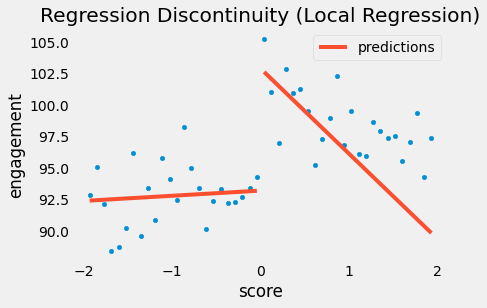

In [28]:
ax = df.plot.scatter(x="score", y="engagement", color="C0")
df.assign(predictions=model.fittedvalues).plot(x="score", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)")
plt.grid(None);